In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas_datareader import data

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.layers import TimeDistributed
from keras.layers import Bidirectional

Using TensorFlow backend.


In [4]:
#getting amazon stock data from 2010 to 2019
ticker = 'AMZN'
start_date = '2005-01-01'
end_date = '2019-12-29'
panel_data = data.get_data_yahoo(ticker, start_date, end_date)

In [5]:
print(panel_data.head(5))

                 High        Low       Open      Close    Volume  Adj Close
Date                                                                       
2005-01-03  45.439999  44.209999  44.950001  44.520000  10446500  44.520000
2005-01-04  43.259998  41.500000  42.669998  42.139999  19418500  42.139999
2005-01-05  42.759998  41.560001  41.570000  41.770000   8354200  41.770000
2005-01-06  42.250000  40.900002  41.810001  41.049999   8700900  41.049999
2005-01-07  42.689999  41.160000  41.380001  42.320000   9836600  42.320000


C:\Users\gowth\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


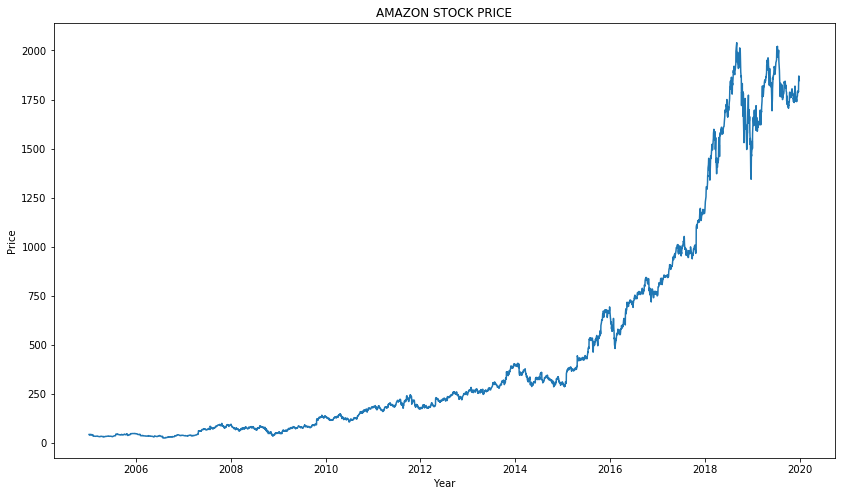

In [6]:
#Visualising the stock market price
fig = plt.figure(figsize = (14, 8), num = 61)
ax = fig.gca()
plt.plot(panel_data['Adj Close'])
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('AMAZON STOCK PRICE')
plt.show()

In [7]:
#Preparing data from LTSM
panel_data['Date'] = pd.to_datetime(panel_data.index, format = '%Y-%m-%d')
panel_data.index = panel_data['Date']

new_data = panel_data[['Adj Close']].copy()
new_data.head(5)

,Adj Close
Date,
2005-01-03,44.520000
2005-01-04,42.139999
2005-01-05,41.770000
2005-01-06,41.049999
2005-01-07,42.320000


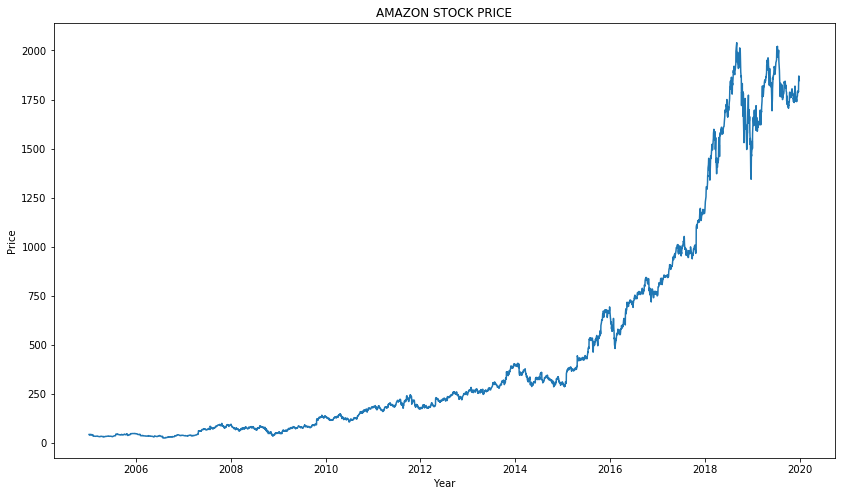

In [8]:
#Visualising the stock market price
fig1 = plt.figure(figsize = (14, 8), num = 61)
ax1 = fig.gca()
plt.plot(new_data)
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('AMAZON STOCK PRICE')
plt.show()

In [9]:
train_raw_data = new_data.loc[:'2016']
test_raw_data = new_data.loc['2017': ]

print(train_raw_data.shape)
print(test_raw_data.shape)

(3021, 1)
(753, 1)


In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

In [11]:
train_data = scaler.fit_transform(train_raw_data)
test_data = scaler.transform(test_raw_data)

In [12]:
print(train_raw_data['Adj Close'])
print(train_data)
print(scaler.inverse_transform(train_data))

Date
2005-01-03     44.520000
2005-01-04     42.139999
2005-01-05     41.770000
2005-01-06     41.049999
2005-01-07     42.320000
                 ...    
2016-12-23    760.590027
2016-12-27    771.400024
2016-12-28    772.130005
2016-12-29    765.150024
2016-12-30    749.869995
Name: Adj Close, Length: 3021, dtype: float64
[[0.02254702]
 [0.01963851]
 [0.01918635]
 ...
 [0.91173058]
 [0.90320062]
 [0.8845275 ]]
[[ 44.52000046]
 [ 42.13999939]
 [ 41.77000046]
 ...
 [772.13000488]
 [765.15002441]
 [749.86999512]]


In [13]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []

    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    
    return np.array(dataX), np.array(dataY)  

In [14]:
look_back = 3
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)

In [15]:
print(testY.shape)

(749,)


In [16]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [17]:
print(trainX)

[[[0.02254702 0.01963851 0.01918635]]

 [[0.01963851 0.01918635 0.01830647]]

 [[0.01918635 0.01830647 0.01985849]]

 ...

 [[0.90986079 0.90465488 0.89762803]]

 [[0.90465488 0.89762803 0.9108385 ]]

 [[0.89762803 0.9108385  0.91173058]]]


In [58]:
model = Sequential()
model.add(LSTM(4, activation = 'relu', input_shape = (1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 4)                 128       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 133
Trainable params: 133
Non-trainable params: 0
_________________________________________________________________


In [59]:
model_fit_data = model.fit(trainX, trainY, epochs = 500, verbose = 2, batch_size = 128, validation_data = (testX, testY))

Train on 3017 samples, validate on 749 samples
Epoch 1/500
 - 1s - loss: 0.1501 - val_loss: 5.1045
Epoch 2/500
 - 0s - loss: 0.1245 - val_loss: 4.4568
Epoch 3/500
 - 0s - loss: 0.1026 - val_loss: 3.8312
Epoch 4/500
 - 0s - loss: 0.0835 - val_loss: 3.2015
Epoch 5/500
 - 0s - loss: 0.0667 - val_loss: 2.5513
Epoch 6/500
 - 0s - loss: 0.0523 - val_loss: 1.9090
Epoch 7/500
 - 0s - loss: 0.0406 - val_loss: 1.3217
Epoch 8/500
 - 0s - loss: 0.0317 - val_loss: 0.8412
Epoch 9/500
 - 0s - loss: 0.0250 - val_loss: 0.5032
Epoch 10/500
 - 0s - loss: 0.0202 - val_loss: 0.2800
Epoch 11/500
 - 0s - loss: 0.0165 - val_loss: 0.1395
Epoch 12/500
 - 0s - loss: 0.0134 - val_loss: 0.0582
Epoch 13/500
 - 0s - loss: 0.0108 - val_loss: 0.0197
Epoch 14/500
 - 0s - loss: 0.0085 - val_loss: 0.0076
Epoch 15/500
 - 0s - loss: 0.0067 - val_loss: 0.0151
Epoch 16/500
 - 0s - loss: 0.0052 - val_loss: 0.0377
Epoch 17/500
 - 0s - loss: 0.0041 - val_loss: 0.0703
Epoch 18/500
 - 0s - loss: 0.0033 - val_loss: 0.1050
Epoch 19

 - 0s - loss: 8.4719e-05 - val_loss: 0.0269
Epoch 147/500
 - 0s - loss: 8.4961e-05 - val_loss: 0.0271
Epoch 148/500
 - 0s - loss: 8.4893e-05 - val_loss: 0.0273
Epoch 149/500
 - 0s - loss: 8.4775e-05 - val_loss: 0.0280
Epoch 150/500
 - 0s - loss: 8.4947e-05 - val_loss: 0.0272
Epoch 151/500
 - 0s - loss: 8.4393e-05 - val_loss: 0.0278
Epoch 152/500
 - 0s - loss: 8.4639e-05 - val_loss: 0.0267
Epoch 153/500
 - 0s - loss: 8.4520e-05 - val_loss: 0.0268
Epoch 154/500
 - 0s - loss: 8.4948e-05 - val_loss: 0.0280
Epoch 155/500
 - 0s - loss: 8.4620e-05 - val_loss: 0.0279
Epoch 156/500
 - 0s - loss: 8.4437e-05 - val_loss: 0.0273
Epoch 157/500
 - 0s - loss: 8.4011e-05 - val_loss: 0.0268
Epoch 158/500
 - 0s - loss: 8.4124e-05 - val_loss: 0.0269
Epoch 159/500
 - 0s - loss: 8.4211e-05 - val_loss: 0.0272
Epoch 160/500
 - 0s - loss: 8.3861e-05 - val_loss: 0.0275
Epoch 161/500
 - 0s - loss: 8.3648e-05 - val_loss: 0.0267
Epoch 162/500
 - 0s - loss: 8.3799e-05 - val_loss: 0.0272
Epoch 163/500
 - 0s - loss: 

Epoch 288/500
 - 0s - loss: 7.2534e-05 - val_loss: 0.0329
Epoch 289/500
 - 0s - loss: 7.2103e-05 - val_loss: 0.0353
Epoch 290/500
 - 0s - loss: 7.2314e-05 - val_loss: 0.0287
Epoch 291/500
 - 0s - loss: 7.2042e-05 - val_loss: 0.0336
Epoch 292/500
 - 0s - loss: 7.1742e-05 - val_loss: 0.0314
Epoch 293/500
 - 0s - loss: 7.1676e-05 - val_loss: 0.0310
Epoch 294/500
 - 0s - loss: 7.2308e-05 - val_loss: 0.0327
Epoch 295/500
 - 0s - loss: 7.1966e-05 - val_loss: 0.0305
Epoch 296/500
 - 0s - loss: 7.1956e-05 - val_loss: 0.0352
Epoch 297/500
 - 0s - loss: 7.1929e-05 - val_loss: 0.0311
Epoch 298/500
 - 0s - loss: 7.2364e-05 - val_loss: 0.0382
Epoch 299/500
 - 0s - loss: 7.2489e-05 - val_loss: 0.0338
Epoch 300/500
 - 0s - loss: 7.3150e-05 - val_loss: 0.0330
Epoch 301/500
 - 0s - loss: 7.0680e-05 - val_loss: 0.0327
Epoch 302/500
 - 0s - loss: 7.1037e-05 - val_loss: 0.0373
Epoch 303/500
 - 0s - loss: 7.1661e-05 - val_loss: 0.0298
Epoch 304/500
 - 0s - loss: 7.1890e-05 - val_loss: 0.0330
Epoch 305/500


Epoch 430/500
 - 0s - loss: 6.0761e-05 - val_loss: 0.0312
Epoch 431/500
 - 0s - loss: 6.0633e-05 - val_loss: 0.0321
Epoch 432/500
 - 0s - loss: 6.0451e-05 - val_loss: 0.0293
Epoch 433/500
 - 0s - loss: 6.0530e-05 - val_loss: 0.0318
Epoch 434/500
 - 0s - loss: 6.1906e-05 - val_loss: 0.0291
Epoch 435/500
 - 0s - loss: 6.4627e-05 - val_loss: 0.0282
Epoch 436/500
 - 0s - loss: 6.2509e-05 - val_loss: 0.0316
Epoch 437/500
 - 0s - loss: 6.0669e-05 - val_loss: 0.0291
Epoch 438/500
 - 0s - loss: 6.1429e-05 - val_loss: 0.0279
Epoch 439/500
 - 0s - loss: 6.2063e-05 - val_loss: 0.0270
Epoch 440/500
 - 0s - loss: 6.0115e-05 - val_loss: 0.0288
Epoch 441/500
 - 0s - loss: 6.2005e-05 - val_loss: 0.0305
Epoch 442/500
 - 0s - loss: 6.0010e-05 - val_loss: 0.0292
Epoch 443/500
 - 0s - loss: 6.1813e-05 - val_loss: 0.0278
Epoch 444/500
 - 0s - loss: 6.0626e-05 - val_loss: 0.0286
Epoch 445/500
 - 0s - loss: 6.0481e-05 - val_loss: 0.0284
Epoch 446/500
 - 0s - loss: 6.0398e-05 - val_loss: 0.0296
Epoch 447/500


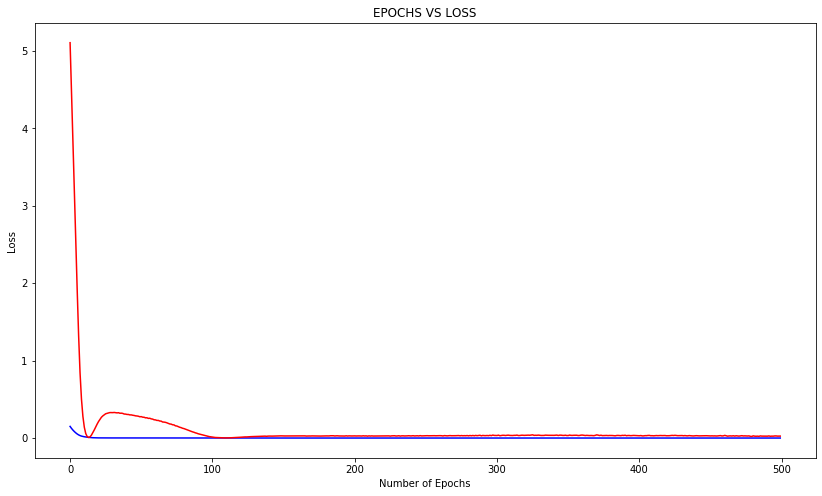

In [61]:
fig2 = plt.figure(figsize = (14, 8), num = 61)
ax2 = fig2.gca()
plt.plot(model_fit_data.history['loss'], 'b')
plt.plot(model_fit_data.history['val_loss'], 'r')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('EPOCHS VS LOSS')
plt.show()

In [77]:
prediciton = scaler.inverse_transform(model.predict(testX))
testY1 = np.reshape(testY, newshape = (len(testY), 1))
testY1 = scaler.inverse_transform(testY1)
from sklearn.metrics import mean_absolute_error

error = mean_absolute_error(testY1, prediction[:, 0])
print(error)

ValueError: Error when checking input: expected lstm_5_input to have shape (1, 3) but got array with shape (3, 1)

In [65]:
#LSTM with time-step equal to number of columns
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

model2 = Sequential()
model2.add(LSTM(4, activation = 'relu', input_shape = (look_back, 1)))
model2.add(Dense(1))
model2.compile(loss = 'mean_squared_error', optimizer = 'adam')
model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [67]:
model2_fit__data = model2.fit(trainX, trainY, epochs = 500, verbose = 2, batch_size = 128, validation_data = (testX, testY))

Train on 3017 samples, validate on 749 samples
Epoch 1/500
 - 1s - loss: 0.0616 - val_loss: 1.5365
Epoch 2/500
 - 0s - loss: 0.0389 - val_loss: 1.0077
Epoch 3/500
 - 0s - loss: 0.0238 - val_loss: 0.5192
Epoch 4/500
 - 0s - loss: 0.0157 - val_loss: 0.2039
Epoch 5/500
 - 0s - loss: 0.0118 - val_loss: 0.0474
Epoch 6/500
 - 0s - loss: 0.0085 - val_loss: 0.0156
Epoch 7/500
 - 0s - loss: 0.0059 - val_loss: 0.0945
Epoch 8/500
 - 0s - loss: 0.0038 - val_loss: 0.2682
Epoch 9/500
 - 0s - loss: 0.0025 - val_loss: 0.5090
Epoch 10/500
 - 0s - loss: 0.0017 - val_loss: 0.7440
Epoch 11/500
 - 0s - loss: 0.0013 - val_loss: 0.9252
Epoch 12/500
 - 0s - loss: 0.0012 - val_loss: 1.0255
Epoch 13/500
 - 0s - loss: 0.0011 - val_loss: 1.0744
Epoch 14/500
 - 0s - loss: 0.0011 - val_loss: 1.0693
Epoch 15/500
 - 0s - loss: 0.0011 - val_loss: 1.0573
Epoch 16/500
 - 0s - loss: 0.0010 - val_loss: 1.0190
Epoch 17/500
 - 0s - loss: 0.0010 - val_loss: 0.9672
Epoch 18/500
 - 0s - loss: 9.8304e-04 - val_loss: 0.9315
Epoc

Epoch 145/500
 - 0s - loss: 7.8516e-05 - val_loss: 0.0034
Epoch 146/500
 - 0s - loss: 7.8459e-05 - val_loss: 0.0030
Epoch 147/500
 - 0s - loss: 7.7713e-05 - val_loss: 0.0028
Epoch 148/500
 - 0s - loss: 7.9060e-05 - val_loss: 0.0028
Epoch 149/500
 - 0s - loss: 7.7580e-05 - val_loss: 0.0031
Epoch 150/500
 - 0s - loss: 7.7557e-05 - val_loss: 0.0029
Epoch 151/500
 - 0s - loss: 7.7590e-05 - val_loss: 0.0030
Epoch 152/500
 - 0s - loss: 7.7320e-05 - val_loss: 0.0026
Epoch 153/500
 - 0s - loss: 7.8677e-05 - val_loss: 0.0029
Epoch 154/500
 - 0s - loss: 7.7462e-05 - val_loss: 0.0026
Epoch 155/500
 - 0s - loss: 7.7743e-05 - val_loss: 0.0026
Epoch 156/500
 - 0s - loss: 7.6576e-05 - val_loss: 0.0027
Epoch 157/500
 - 0s - loss: 7.6920e-05 - val_loss: 0.0029
Epoch 158/500
 - 0s - loss: 7.9332e-05 - val_loss: 0.0028
Epoch 159/500
 - 0s - loss: 7.8597e-05 - val_loss: 0.0027
Epoch 160/500
 - 0s - loss: 7.7315e-05 - val_loss: 0.0023
Epoch 161/500
 - 0s - loss: 7.7256e-05 - val_loss: 0.0024
Epoch 162/500


Epoch 287/500
 - 0s - loss: 7.0013e-05 - val_loss: 0.0019
Epoch 288/500
 - 0s - loss: 7.0338e-05 - val_loss: 0.0020
Epoch 289/500
 - 0s - loss: 7.1406e-05 - val_loss: 0.0017
Epoch 290/500
 - 0s - loss: 7.0420e-05 - val_loss: 0.0017
Epoch 291/500
 - 0s - loss: 7.4262e-05 - val_loss: 0.0020
Epoch 292/500
 - 0s - loss: 6.9670e-05 - val_loss: 0.0018
Epoch 293/500
 - 0s - loss: 7.0632e-05 - val_loss: 0.0021
Epoch 294/500
 - 0s - loss: 7.0710e-05 - val_loss: 0.0017
Epoch 295/500
 - 0s - loss: 6.9948e-05 - val_loss: 0.0018
Epoch 296/500
 - 0s - loss: 7.0351e-05 - val_loss: 0.0018
Epoch 297/500
 - 0s - loss: 7.0590e-05 - val_loss: 0.0017
Epoch 298/500
 - 0s - loss: 6.9378e-05 - val_loss: 0.0020
Epoch 299/500
 - 0s - loss: 7.0378e-05 - val_loss: 0.0017
Epoch 300/500
 - 0s - loss: 7.0182e-05 - val_loss: 0.0019
Epoch 301/500
 - 0s - loss: 6.9642e-05 - val_loss: 0.0019
Epoch 302/500
 - 0s - loss: 7.0972e-05 - val_loss: 0.0017
Epoch 303/500
 - 0s - loss: 7.0517e-05 - val_loss: 0.0018
Epoch 304/500


Epoch 429/500
 - 0s - loss: 6.2775e-05 - val_loss: 0.0014
Epoch 430/500
 - 0s - loss: 6.5258e-05 - val_loss: 0.0013
Epoch 431/500
 - 0s - loss: 6.2651e-05 - val_loss: 0.0013
Epoch 432/500
 - 0s - loss: 6.3097e-05 - val_loss: 0.0014
Epoch 433/500
 - 0s - loss: 6.3389e-05 - val_loss: 0.0013
Epoch 434/500
 - 0s - loss: 6.3862e-05 - val_loss: 0.0013
Epoch 435/500
 - 0s - loss: 6.2131e-05 - val_loss: 0.0014
Epoch 436/500
 - 0s - loss: 6.3586e-05 - val_loss: 0.0013
Epoch 437/500
 - 0s - loss: 6.5042e-05 - val_loss: 0.0013
Epoch 438/500
 - 0s - loss: 6.3635e-05 - val_loss: 0.0013
Epoch 439/500
 - 0s - loss: 6.3106e-05 - val_loss: 0.0015
Epoch 440/500
 - 0s - loss: 6.5440e-05 - val_loss: 0.0013
Epoch 441/500
 - 0s - loss: 6.3573e-05 - val_loss: 0.0014
Epoch 442/500
 - 0s - loss: 6.4721e-05 - val_loss: 0.0013
Epoch 443/500
 - 0s - loss: 6.2258e-05 - val_loss: 0.0013
Epoch 444/500
 - 0s - loss: 6.4392e-05 - val_loss: 0.0013
Epoch 445/500
 - 0s - loss: 6.2123e-05 - val_loss: 0.0013
Epoch 446/500


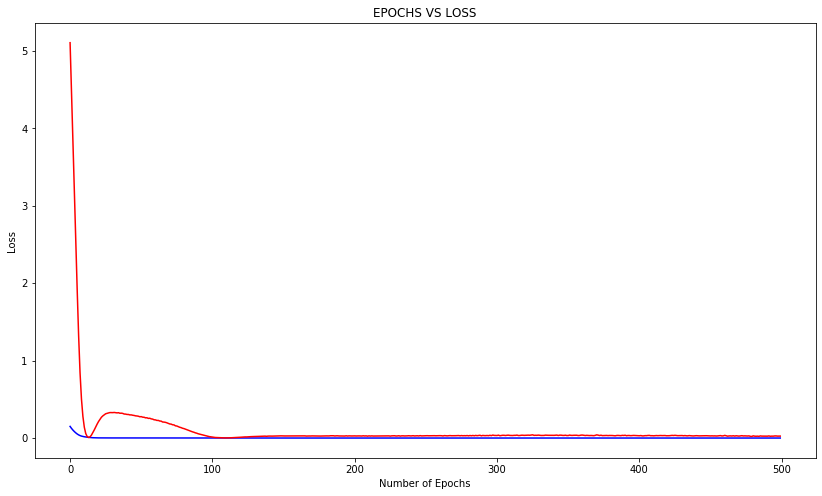

In [69]:
fig3 = plt.figure(figsize = (14, 8), num = 61)
ax3 = fig3.gca()
plt.plot(model_fit_data.history['loss'], 'b')
plt.plot(model_fit_data.history['val_loss'], 'r')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('EPOCHS VS LOSS')
plt.show()

In [76]:
predicition = model2.predict(testX)
prediciton = scaler.inverse_transform(prediction)
testY1 = np.reshape(testY, newshape = (len(testY), 1))
testY1 = scaler.inverse_transform(testY1)
from sklearn.metrics import mean_absolute_error

error = mean_absolute_error(testY1, prediction[:, 0])
print(error)

1466.9530145814804
